In [1]:
import pandas as pd
from skimage import io, transform, color
import os
from tqdm import tqdm
import numpy as np
import csv
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import cv2
from keras.models import Sequential, Model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Input
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
%matplotlib inline

print(f'TensorFlow {tf.__version__}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



TensorFlow 2.14.0
Num GPUs Available:  0


# **Loading of Data**

Loading the UTKFace data into a matrix, X is the data en y the shape (3,1) target

RAW Flatten for Feature Extractor

In [ ]:
errors = 0
image_path = 'UTKFace'

X = []
y = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        new_row = list(map(float, file.split("_")[:3]))
        y.append(new_row)
        color_image = color_image.reshape(-1).tolist()
        X.append(color_image)
    except Exception as e:
        errors += 1


In [33]:
print(len(X))
print(len(X[0]))

23705
120000


In [42]:
print(len(y))
print(len(y[0]))

23705
3


RAW Flatten

In [3]:
errors = 0
image_path = 'UTKFace'

FLATX = []
FLATy = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        new_row = list(map(float, file.split("_")[:3]))
        FLATy.append(new_row)
        FLATX.append(np.array(color_image).reshape(-1))
    except Exception as e:
        errors += 1

100%|██████████| 23708/23708 [02:42<00:00, 145.80it/s]


In [4]:
FLATX_np = np.array(FLATX)

In [5]:
FLATy_np = np.array(FLATy)

In [141]:
print(len(FLATX_np))
print(len(FLATX_np[0]))



23705
120000


RAW 3D

In [2]:
errors = 0
image_path = 'UTKFace'

X3D = []
y3D = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        color_image = transform.resize(color_image, (200, 200))
        color_image = color_image/255.0
        new_row = list(map(float, file.split("_")[:3]))
        y3D.append(new_row)
        X3D.append(color_image)
    except Exception as e:
        errors += 1


100%|██████████| 23708/23708 [04:51<00:00, 81.23it/s]


In [ ]:
print(X3D)

In [3]:
X3D_np = np.array(X3D)

In [4]:
y3D_np = np.array(y3D)

In [ ]:
print(len(X3D_np))
print(len(X3D_np[0]))
print(len(X3D_np[0,0]))
print(len(X3D_np[0,0,0]))

23705
50
50
3


# **Bilateral Filter**

Let's apply a Bilateral Filter to all the images

In [213]:
image_directory = 'UTKFace'

image_files = os.listdir(image_directory)

for image_file in tqdm(image_files):
    img = cv2.imread(os.path.join(image_directory, image_file))
    
    # Apply bilateral filter with d=15, sigmaColor=75, sigmaSpace=75
    bilateral = cv2.bilateralFilter(img, 15, 75, 75)
    
    cv2.imwrite(os.path.join("filtered_images", image_file), bilateral)

100%|██████████| 23708/23708 [04:44<00:00, 83.38it/s]


In [5]:
errors = 0
image_path = 'filtered_images'

FILTEREDX = []
FILTEREDy = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        new_row = list(map(float, file.split("_")[:3]))
        color_image = transform.resize(color_image, (200, 200))
        color_image = color_image/255.0
        FILTEREDy.append(new_row)
        FILTEREDX.append(color_image)
    except Exception as e:
        errors += 1

100%|██████████| 23708/23708 [04:39<00:00, 84.87it/s]


In [6]:
FILTEREDX_np = np.array(FILTEREDX)

In [7]:
FILTEREDy_np = np.array(FILTEREDy)

In [ ]:
print(len(FILTEREDX_np))
print(len(FILTEREDX_np[0]))
print(len(FILTEREDX_np[0,0]))
print(len(FILTEREDX_np[0,0,0]))

23705
200
200
3


# **Feature Extraction**

We performed a 1000 components PCA on the faltten data

In [34]:
pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X)

In [35]:
print(len(X_pca))
print(len(X_pca[0]))

23705
1000


Let's save the processed data

In [36]:
np.savetxt("X_PCA_"+str(len(X_pca[0]))+"_components.csv", X_pca, delimiter=",")

In [12]:
np.savetxt("Target.csv", y, delimiter=",")

In [37]:
X = np.array(X_pca)
y = np.array(y)

When code isn't compiled, run this to load data with PCA

In [9]:
X = pd.read_csv('X_PCA_1000_components.csv').to_numpy()

In [10]:
y = pd.read_csv('Target.csv').to_numpy()

# **Data Analysis**

Feature Engineering


In [109]:
etnicity_dict = {0:'Caucasian', 1:'African', 2:'Asian' , 3:'Indian', 4:'Arabian'}

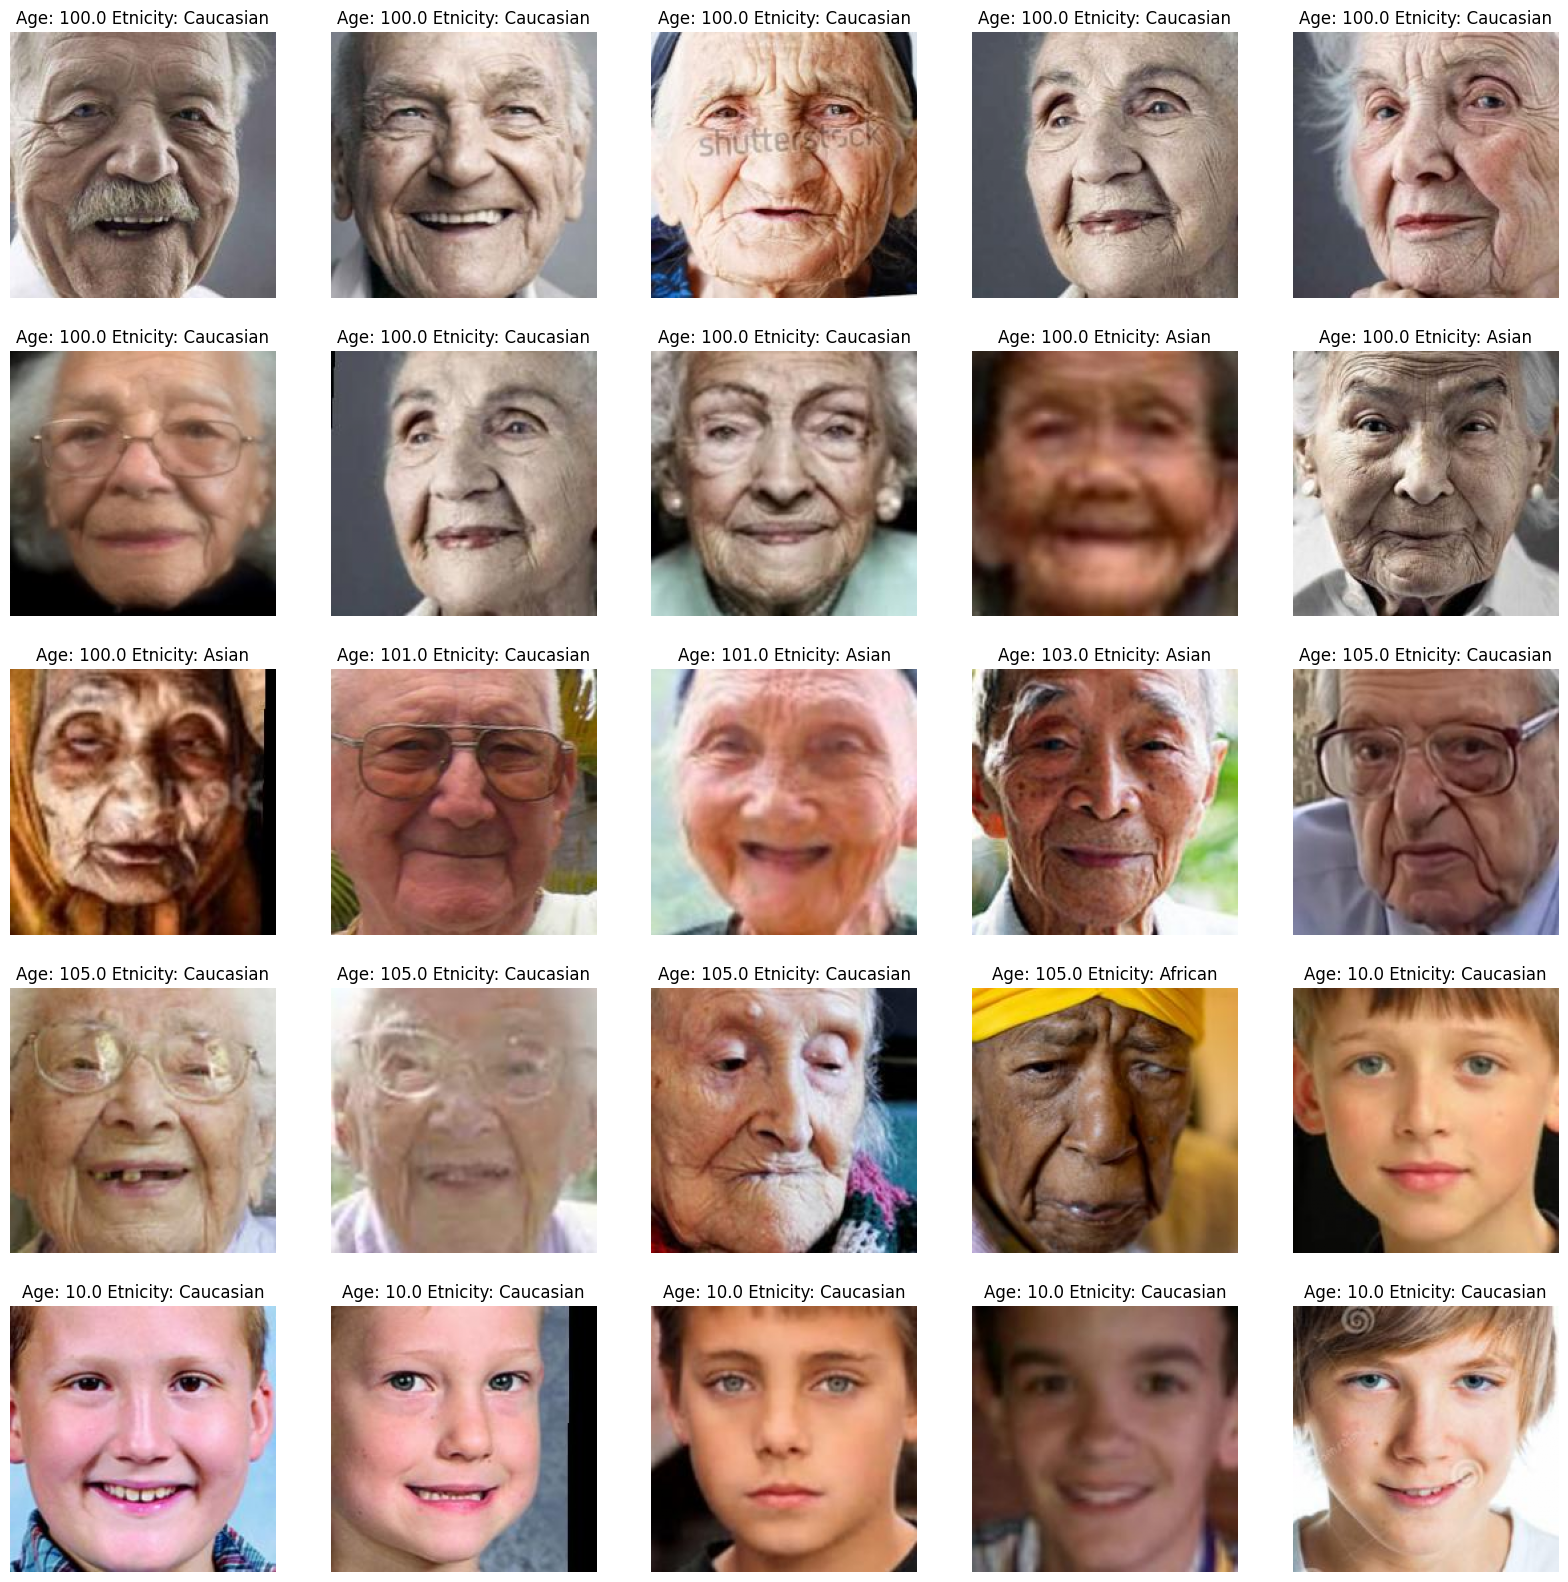

In [118]:
plt.figure(figsize=(20, 20))
images = X3D_np[0:25]

for index, image in enumerate(images):
    plt.subplot(5, 5, index+1)
    image = np.array(image)
    plt.imshow(image)
    plt.title(f"Age: {y3D_np.T[0][index]} Etnicity: {etnicity_dict[y3D_np.T[2][index]]}")
    plt.axis('off')

Null value checking

In [39]:
df = pd.DataFrame(X)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 180.9 MB


In [40]:
df = pd.DataFrame(y)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23705 non-null  float64
 1   1       23705 non-null  float64
 2   2       23705 non-null  float64
dtypes: float64(3)
memory usage: 555.7 KB


Bias per class in the 3 variables

Age

In [105]:
df = pd.DataFrame(y)
df[0].value_counts()

0
26.0     2197
1.0      1123
28.0      918
35.0      880
24.0      859
         ... 
115.0       3
91.0        2
101.0       2
103.0       1
111.0       1
Name: count, Length: 104, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3624736495.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[0], palette="Set1")


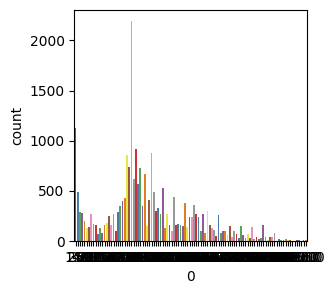

In [86]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[0], palette="Set1")
plt.show()

C:\Users\geogd\AppData\Local\Temp\ipykernel_13672\3841527020.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[0])


<Axes: xlabel='0', ylabel='Density'>

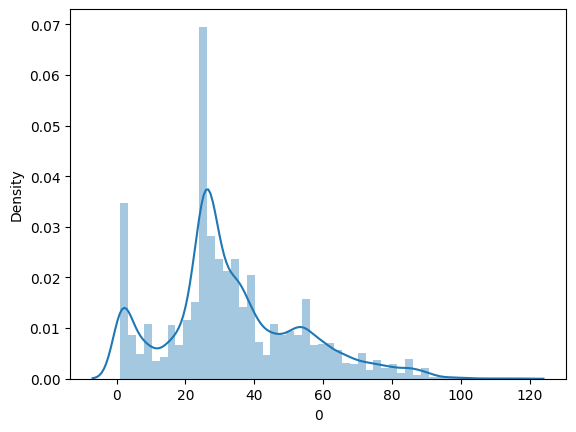

In [106]:
sns.distplot(df[0])

Gender

In [ ]:
df[1].value_counts()

1
0.0    12391
1.0    11314
Name: count, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3180355283.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[1], palette="Set1")


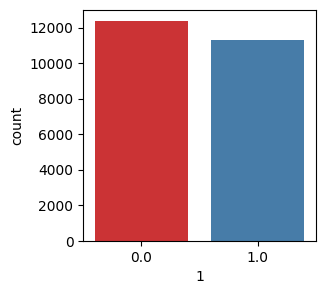

In [87]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[1], palette="Set1")
plt.show()

0 for men

1 for women

Race

In [ ]:
df[2].value_counts()

2
0.0    10078
1.0     4526
3.0     3975
2.0     3434
4.0     1692
Name: count, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3471218125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[2], palette="Set1")


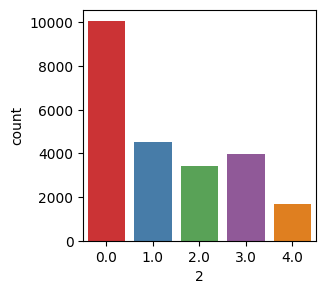

In [89]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[2], palette="Set1")
plt.show()

0 for caucasian

1 for african

2 for asian

3 for indian

4 for arabian

Duplicates

In [51]:
df = pd.DataFrame(X)
count_duplicates = df[df.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 303


Outliers

In [74]:
df = pd.DataFrame(X)
pca = PCA(n_components=2)
X_pca_to_plot = pca.fit_transform(df)


{'whiskers': [<matplotlib.lines.Line2D at 0x14f0855bc10>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x14f07651190>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x14f0855bd50>,
  ...],
 'medians': [<matplotlib.lines.Line2D at 0x14f07652310>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x14f07650990>,
  ...],
 'means': []}

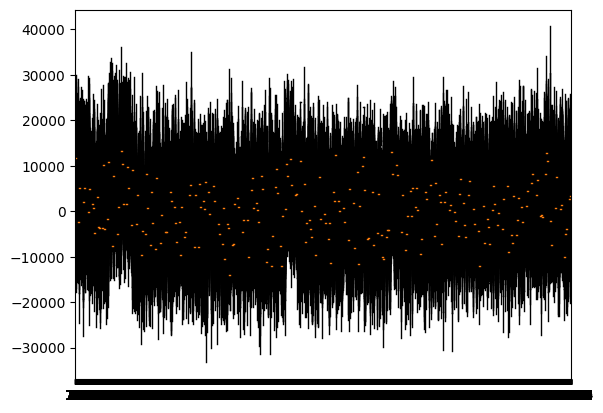

In [94]:
plt.boxplot(X_pca_to_plot.T)

# **Sampling Data**

Feature Engineering

Feature Extracted

In [11]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

df_X[len(df_X.columns)] = df_y.iloc[:, 0]  # Add the first column from df_y to df_X
df_X[len(df_X.columns)] = df_y.iloc[:, 1]  # Add the second column from df_y to df_X

rus = RandomUnderSampler(sampling_strategy={0.0: 5000}, random_state=45)
X_sm, y_sm = rus.fit_resample(df_X, df_y[2])

X_sm = pd.DataFrame(X_sm)
y_sm = pd.DataFrame(y_sm)

y_sm[len(y_sm.columns)-1] = X_sm.iloc[:, -2]  # Add the second last column from X_sm to y_sm
y_sm[len(y_sm.columns)-1] = X_sm.iloc[:, -1]  # Add the last column from X_sm to y_sm

X_sm = X_sm.iloc[:, :-2]

first_column = y_sm.columns[0]
y_sm[first_column] = y_sm.pop(first_column)
y_sm["2"] = first_column
y_sm = y_sm.iloc[:, :-1]

index_list = y_sm.index.tolist()


In [120]:
print(X_sm)

                0            1            2            3            4    \
18377   2296.076508 -1862.353361 -1225.816727 -3484.615567 -3318.919041   
21946   6383.955612 -1431.902605  5851.377249 -6655.786278   -15.376132   
21071   7925.125834 -4800.398440 -8328.776212 -3051.826755 -3352.779244   
23507  15316.718215  7028.715548 -1002.286979 -4512.399714  1567.161942   
5856    9186.421765  1653.202289 -2050.579457  1697.777770  3337.469566   
...             ...          ...          ...          ...          ...   
23672 -13320.395261  5969.382904  5982.558307  4670.958813 -2884.429090   
23673  -4920.917868 -4034.593984  5101.058227  2575.320812  -595.430114   
23701  15546.410828 -2920.783906  1319.805393  4600.437843 -1830.383603   
23702   5650.698783 -5956.548888 -8157.927524  3332.458271 -2883.382598   
23703  10661.937162  -661.109964   500.723816   497.227619 -2505.362284   

               5            6            7            8            9    ...  \
18377 -2345.497392  

In [121]:
print(y_sm)

          0    1    2
18377  52.0  0.0  0.0
21946  71.0  0.0  0.0
21071  64.0  1.0  0.0
23507  95.0  1.0  0.0
5856   26.0  0.0  0.0
...     ...  ...  ...
23672   9.0  0.0  4.0
23673   9.0  0.0  4.0
23701   9.0  1.0  4.0
23702   9.0  1.0  4.0
23703   9.0  1.0  4.0

[18627 rows x 3 columns]


C:\Users\geogd\AppData\Local\Temp\ipykernel_13672\3597133842.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_sm[2], palette="Set1")


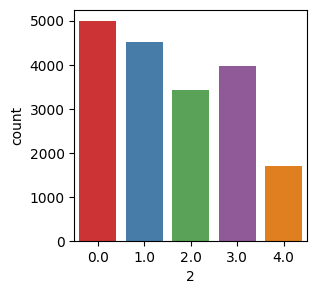

In [122]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=y_sm[2], palette="Set1")
plt.show()

RAW 3D

In [12]:
X3D_np, y3D_np = X3D_np[index_list], y3D_np[index_list]

RAW Flatten

In [16]:
FLATX_np, FLATy_np = FLATX_np[index_list], FLATy_np[index_list]

Bilateral Filter

In [ ]:
FILTEREDX_np, FILTEREDy_np = FILTEREDX_np[index_list], FILTEREDy_np[index_list]

# **Data Split**

Feature Extracted

In [18]:
min_val = X_sm.min(axis=0)
max_val = X_sm.max(axis=0)
X_sm = (X_sm - min_val) / (max_val - min_val)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, shuffle=False)

RAW 3D

In [158]:

X3D_train, X3D_test, y3D_train_age, y3D_test_age = train_test_split(X3D_np, y3D_np.T[0], test_size=0.2, random_state=45)


MemoryError: Unable to allocate 13.3 GiB for an array with shape (14901, 200, 200, 3) and data type float64

RAW Flatten

In [21]:
FLATX_train, FLATX_test, FLATy_train, FLATy_test = train_test_split(FLATX_np, FLATy_np.T[0], test_size=0.2, random_state=45)

Filtered

In [ ]:
FILTEREDX_train, FILTEREDX_test, FILTEREDy_train, FILTEREDy_test = train_test_split(FILTEREDX_np, FILTEREDy_np.T[0], test_size=0.2, random_state=45)


# **Models**

**MLP**

In [23]:
MLP = MLPClassifier(hidden_layer_sizes=(400,300,200,117), activation= 'relu', max_iter=500, random_state=45, solver="sgd")

**CNN Model One**

In [153]:
input_shape = (200, 200, 3)

inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='sigmoid', name='ethnicity_out') (dropout_2)

CNNOne = Model(inputs=[inputs], outputs=[output_1, output_2])

CNNOne.compile(loss=['sparse_cathegorical_crossentropy', 'mae','mse'], optimizer='adam', metrics=['accuracy'])

In [154]:
plot_model(CNNOne)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


**CNN Model Two**

In [49]:
CNNTwo = Sequential()
CNNTwo.add(Conv2D(256, kernel_size=(7, 7),padding="same",strides=(1,1) ,activation='relu',input_shape=(200, 200, 3)))
CNNTwo.add(Conv2D(128, kernel_size=(5, 5), activation='tanh')) 
CNNTwo.add(MaxPooling2D(pool_size=(3, 3)))
CNNTwo.add(Flatten())
CNNTwo.add(Dense(128, activation='tanh'))
CNNTwo.add(Dense(117, activation='softmax'))

# **Tests**

**MLP RAW**

In [ ]:
#MLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#MLP.fit(RAWX_train, RAWy_train, epochs=100, validation_data=(RAWX_test, RAWy_test))

MLP.fit(FLATX_train, FLATy_train)
y_pred = MLP.predict(FLATX_test)

In [ ]:
accuracy = accuracy_score(y_test.to_numpy().T[0], y_pred)
precision = precision_score(y_test.to_numpy().T[0], y_pred, average='macro')
recall = recall_score(y_test.to_numpy().T[0], y_pred, average='macro')
f1 = f1_score(y_test.to_numpy().T[0], y_pred, average='macro')

# Create a table
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Accuracy", "{:.4f}".format(accuracy)])
table.add_row(["Precision", "{:.4f}".format(precision)])
table.add_row(["Recall", "{:.4f}".format(recall)])
table.add_row(["F1 Score", "{:.4f}".format(f1)])

# Print the table
print(table)

**MLP with feature extractor**

In [108]:
MLP.fit(X_train.to_numpy(), y_train.to_numpy().T[0])
y_pred = MLP.predict(X_test.to_numpy())

In [109]:
accuracy = accuracy_score(y_test.to_numpy().T[0], y_pred)
precision = precision_score(y_test.to_numpy().T[0], y_pred, average='macro')
recall = recall_score(y_test.to_numpy().T[0], y_pred, average='macro')
f1 = f1_score(y_test.to_numpy().T[0], y_pred, average='macro')

# Create a table
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Accuracy", "{:.4f}".format(accuracy)])
table.add_row(["Precision", "{:.4f}".format(precision)])
table.add_row(["Recall", "{:.4f}".format(recall)])
table.add_row(["F1 Score", "{:.4f}".format(f1)])

# Print the table
print(table)

+-----------+--------+
|   Metric  | Value  |
+-----------+--------+
|  Accuracy | 0.0934 |
| Precision | 0.0475 |
|   Recall  | 0.0491 |
|  F1 Score | 0.0345 |
+-----------+--------+


C:\Users\geogd\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**CNN Model One RAW**

In [155]:
print(y3D_train.shape)
print(y3D_test.shape)

(14901,)
(3726,)


In [104]:
CNNOne.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNNOne.fit(X3D_train, y3D_train_age, epochs=100, batch_size=128, verbose=1, validation_data=(X3D_test, y3D_test_age))

history = CNNOne.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)



Epoch 1/100
117/117 [==============================] - 318s 3s/step - loss: 4.1682 - accuracy: 0.0993 - val_loss: 4.0355 - val_accuracy: 0.0907
Epoch 2/100
 96/117 [=======================>......] - ETA: 53s - loss: 4.0059 - accuracy: 0.1091

KeyboardInterrupt: 

In [57]:
loss, accuracy = CNNOne.evaluate(X3D_test, y3D_test, verbose=0)
print(f"Pérdida en el conjunto de prueba: {loss}")
print(f"Precisión en el conjunto de prueba: {accuracy}")

print ("La arquitectura del modelo es:  ")
CNNOne.summary()

Pérdida en el conjunto de prueba: 20.460655212402344
Precisión en el conjunto de prueba: 0.10923241823911667
La arquitectura del modelo es:  
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       3584      
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        73792     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 36864)             0         
                                                                 
 dense_10 (Dense)            (None, 32)                1179680   
                                            

**CNN Model One with filters**

In [ ]:
CNNOne.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNNOne.fit(FILTEREDX_train, FILTEREDy_train, epochs=100, validation_data=(FILTEREDX_test, FILTEREDy_test))

**CNN Model Two RAW**

In [ ]:
CNNTwo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNNTwo.fit(X3D_train, y3D_train, epochs=100, validation_data=(X3D_test, y3D_test))

Epoch 1/100
  5/466 [..............................] - ETA: 1:17:24 - loss: 5.5419 - accuracy: 0.0312 

KeyboardInterrupt: 

**CNN Model Two with filters**

In [ ]:
CNNTwo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
CNNTwo.fit(FILTEREDX_train, FILTEREDy_train, epochs=100, validation_data=(FILTEREDX_test, FILTEREDy_test))